# AidSDK部署-单张图像预测

同济子豪兄 2023-9-2 2023-9-4

本代码在AidLux手机端运行

## 导入工具包

In [1]:
import cv2
from cvs import *

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## AidLite初始化

In [2]:
import aidlite_gpu
aidlite = aidlite_gpu.aidlite()

[2023-09-04 11:40:51,694237][/tmp/ipykernel_18180/1811969939.py:2 <module>][DEBUG]:=======init


## 载入TFLite模型

In [3]:
model_path = 'end2end_fp32.tflite'

In [4]:
# 文档：https://docs.aidlux.com/#/intro/ai/ai-aidlite?id=_4fast_annmodel

aidlite.FAST_ANNModel(
    model_path,           # 模型路径
    [1*1024*2048*3*4],    # 输入维度：Batch H W C 字节数
    [1*1024*2048*1*8],    # 输出维度：Batch H W C 字节数
    numberOfThreads=3,    # 加载数据和模型所需要的核数
    enableNNAPI=0         # 是否开启NNAPI
)

Result(id=1, result='load model ok!', error=None)

## 载入图像

In [5]:
img_path = 'watermelon_test1.jpg'

In [6]:
img_bgr = cv2.imread(img_path)

In [7]:
img_bgr.shape

(3712, 5568, 3)

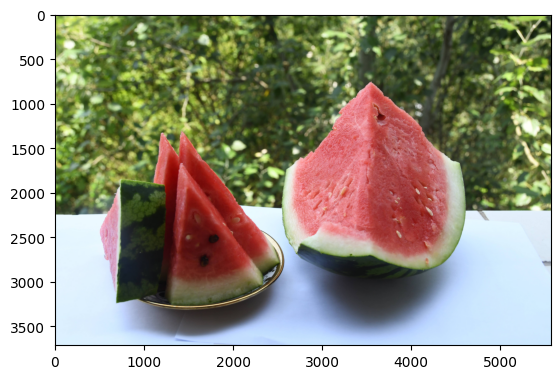

In [8]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 图像预处理

In [9]:
# 尺寸缩放
img_bgr_resize = cv2.resize(img_bgr, (2048, 1024))

# BGR 转 RGB
img_rgb_resize = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)

# 三通道的均值
mean = (0.485, 0.456, 0.406)

# 三通道的标准差
std = (0.229, 0.224, 0.225)

# 归一化
img_tensor = ((img_rgb_resize / 255) - mean) / std
img_tensor = img_tensor.astype('float32')

In [10]:
img_tensor.shape

(1024, 2048, 3)

## 推理预测

In [11]:
# 装填数据
# https://docs.aidlux.com/#/intro/ai/ai-aidlite?id=_5setinput_float32
aidlite.setInput_Float32(img_tensor)

Result(id=91, result=None, error=None)

In [12]:
# 推理预测
# https://docs.aidlux.com/#/intro/ai/ai-aidlite?id=_7invoke
aidlite.invoke() 

Result(id=91, result=None, error=None)

In [13]:
# 获得模型输出结果
output = aidlite.getOutput_Float32()

In [14]:
# 将模型输出结果转 bytes
output_bytes = output.tobytes()

In [15]:
# 再转 int64
pred_mask = np.frombuffer(output_bytes, dtype=np.int64).reshape(1024, 2048)

In [16]:
pred_mask.shape

(1024, 2048)

In [17]:
np.unique(pred_mask)

array([0, 1, 2, 3, 4, 5])

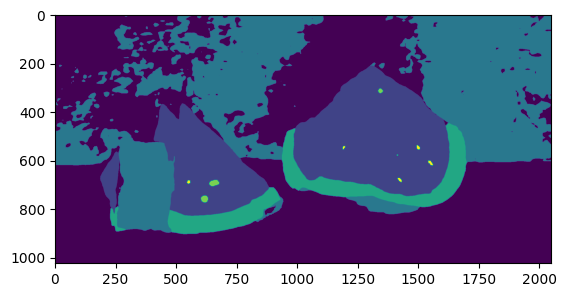

In [18]:
plt.imshow(pred_mask)
plt.show()

## 各类别的配色方案

In [19]:
# 各类别的配色方案（BGR）
palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ['green', [0,200,0]],
    ['white', [144,238,144]],
    ['seed-black', [30,30,30]],
    ['seed-white', [8,189,251]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [20]:
palette_dict

{0: [127, 127, 127],
 1: [0, 0, 200],
 2: [0, 200, 0],
 3: [144, 238, 144],
 4: [30, 30, 30],
 5: [8, 189, 251]}

## 叠加在原图上可视化

In [21]:
opacity = 0.3 # 透明度，越大越接近原图

In [22]:
# 将预测的整数ID，映射为对应类别的颜色
pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
for idx in palette_dict.keys():
    pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
pred_mask_bgr = pred_mask_bgr.astype('uint8')

# 将语义分割预测图和原图叠加显示
pred_viz = cv2.addWeighted(img_bgr_resize, opacity, pred_mask_bgr, 1-opacity, 0)

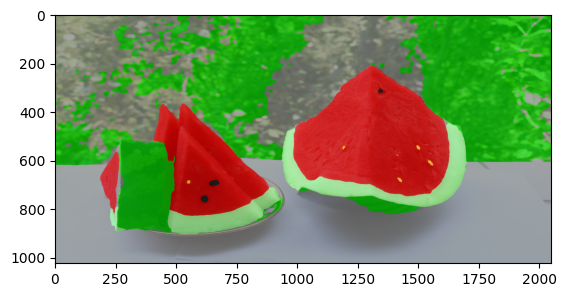

In [23]:
plt.imshow(pred_viz[:,:,::-1])
plt.show()

In [24]:
cv2.imwrite('output-B1.jpg', pred_viz)

True